<h2>Лабораторная работа №3 по курсу "Методы машинного обучения"</h2>

<p><b>Выполнил:</b> Саврасов П.А. группа ИУ5-24М</p>

<h3>Задание</h3>
<p>Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:</p>
<ol>
    <li>масштабирование признаков (не менее чем тремя способами);</li>
    <li>обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);</li>
    <li>обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);</li>
    <li>отбор признаков:
        <ul>
            <li>один метод из группы методов фильтрации (filter methods);</li>
            <li>один метод из группы методов обертывания (wrapper methods);</li>
            <li>один метод из группы методов вложений (embedded methods).</li>
        </ul>
    </li>
</ol>

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import scipy.stats as stats
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

In [189]:
data = pd.read_csv('BankChurners.csv', sep=",")
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,NBS1,NBS2
0,768805383,1,45,1,3,1,1,2,0,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,1,49,0,5,3,0,0,0,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,1,51,1,3,3,1,3,0,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,1,40,0,4,1,3,0,0,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,1,40,1,3,0,1,2,0,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


Масштабирование признаков

In [190]:
data['Total_Trans_Ct'].describe()

count    10127.000000
mean        64.858695
std         23.472570
min         10.000000
25%         45.000000
50%         67.000000
75%         81.000000
max        139.000000
Name: Total_Trans_Ct, dtype: float64

In [191]:
minMaxScaler = MinMaxScaler()
data['Total_Trans_Ct_minmax'] = minMaxScaler.fit_transform(data[['Total_Trans_Ct']])
data['Total_Trans_Ct_minmax'].describe()

count    10127.000000
mean         0.425261
std          0.181958
min          0.000000
25%          0.271318
50%          0.441860
75%          0.550388
max          1.000000
Name: Total_Trans_Ct_minmax, dtype: float64

In [192]:
standardScaler = StandardScaler()
data['Total_Trans_Ct_standard'] = standardScaler.fit_transform(data[['Total_Trans_Ct']])
data['Total_Trans_Ct_standard'].describe()

count    1.012700e+04
mean    -2.245222e-16
std      1.000049e+00
min     -2.337256e+00
25%     -8.460801e-01
50%      9.123036e-02
75%      6.877007e-01
max      3.158792e+00
Name: Total_Trans_Ct_standard, dtype: float64

In [193]:
robustScaler = RobustScaler()
data['Total_Trans_Ct_robust'] = robustScaler.fit_transform(data[['Total_Trans_Ct']])
data['Total_Trans_Ct_robust'].describe()

count    10127.000000
mean        -0.059481
std          0.652016
min         -1.583333
25%         -0.611111
50%          0.000000
75%          0.388889
max          2.000000
Name: Total_Trans_Ct_robust, dtype: float64

Обработка выбросов

In [194]:
def diagnostic_plots(df, variable):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.subplot(2, 2, 1)
    sns.kdeplot(data=data, x=variable)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.boxplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    df[variable].hist(bins=30)  
    plt.show()


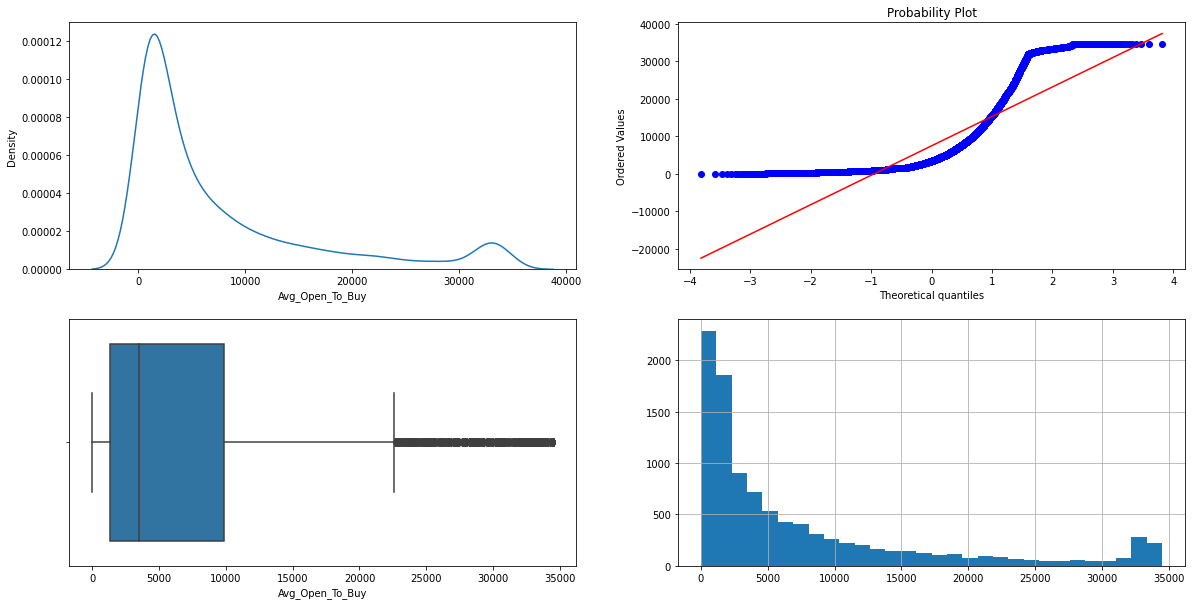

In [195]:
diagnostic_plots(data, 'Avg_Open_To_Buy')

In [196]:
outlierBoundaryType = {
    'SIGMA': 1,
    'QUANTILE': 2,
    'IRQ': 3
}

In [197]:
def get_outlier_boundaries(df, col, outlier_boundary_type):
    if outlier_boundary_type == outlierBoundaryType['SIGMA']:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == outlierBoundaryType['QUANTILE']:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == outlierBoundaryType['IRQ']:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)
    else:
        return 0, 0 
    return lower_boundary, upper_boundary

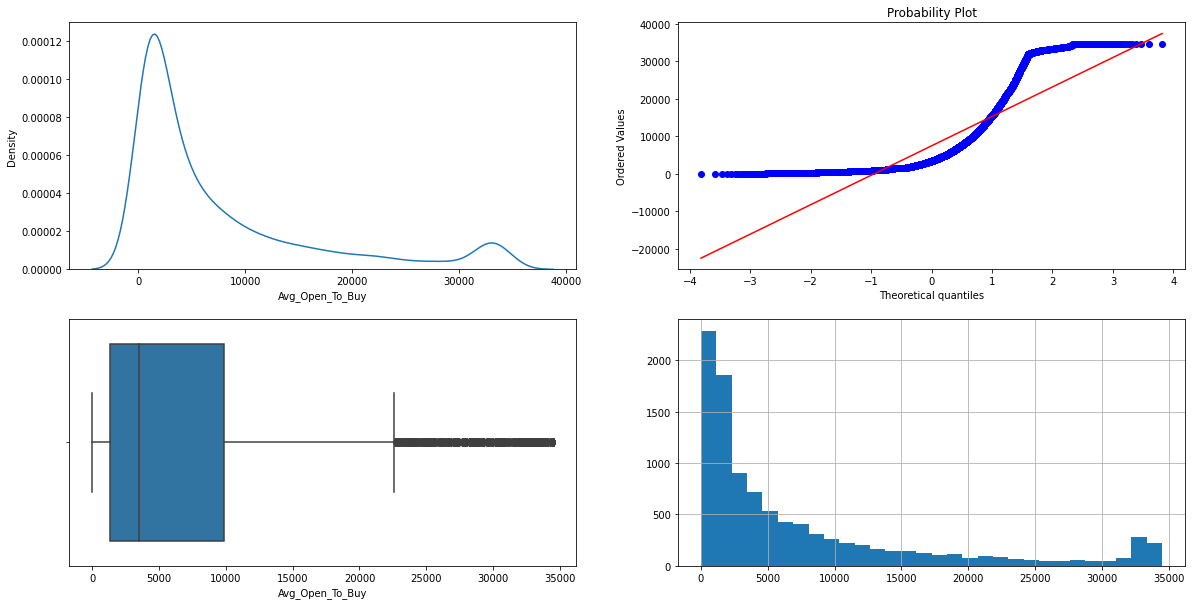

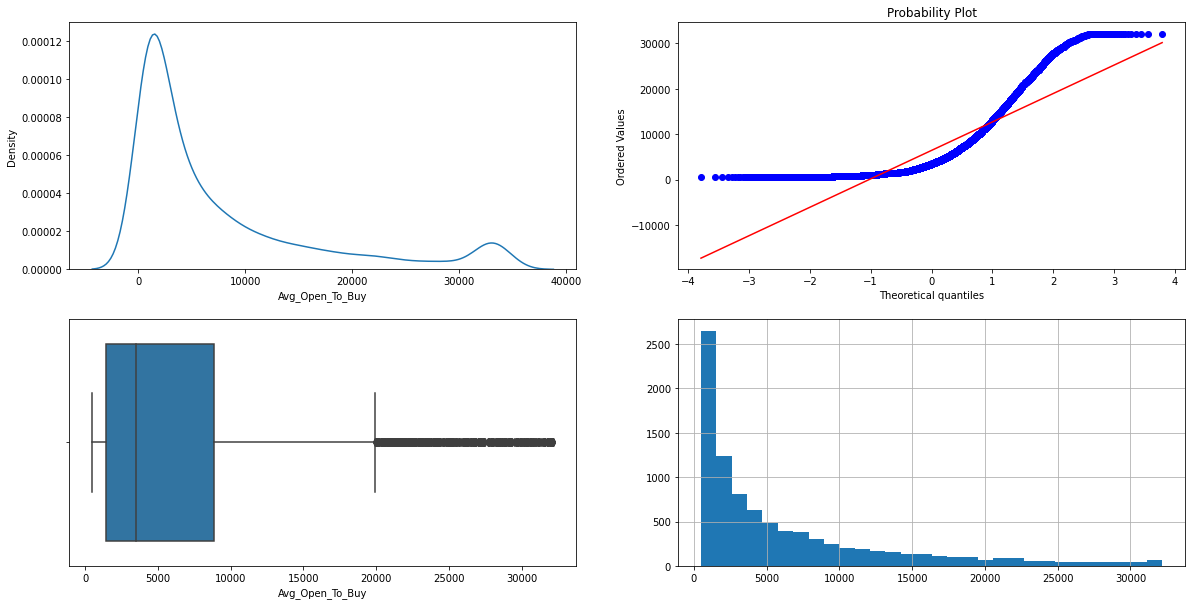

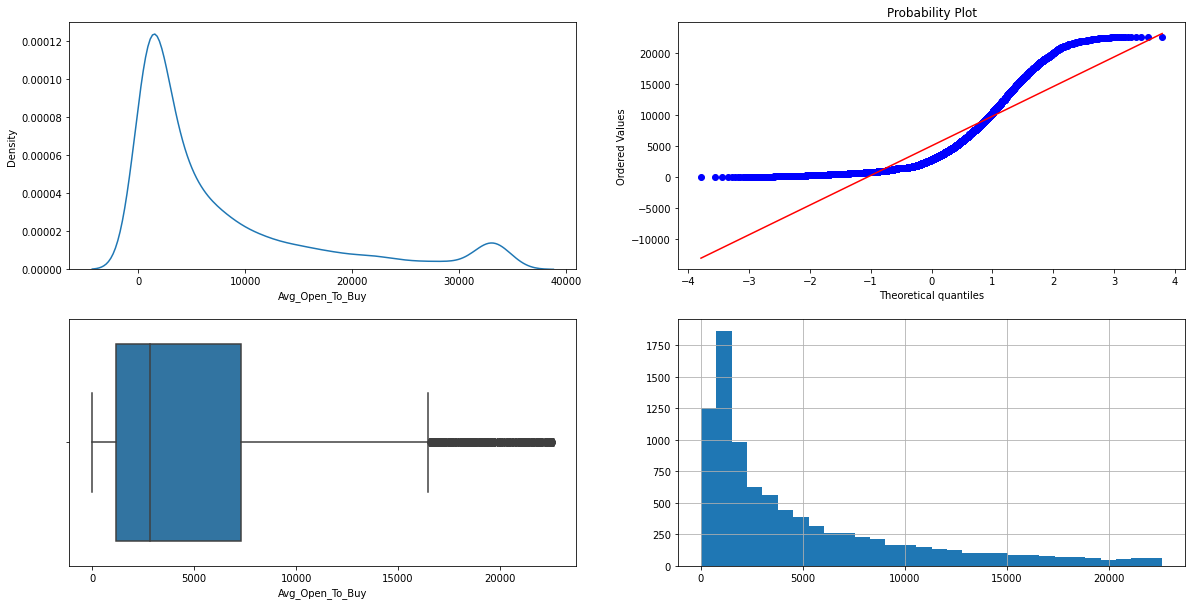

In [198]:
for key, value in outlierBoundaryType.items():
    col = 'Avg_Open_To_Buy'
    lower_boundary, upper_boundary = get_outlier_boundaries(data, col, value)
    outliers_temp = np.where(data[col] > upper_boundary, True, np.where(data[col] < lower_boundary, True, False))

    data_trimmed = data.loc[~(outliers_temp), ]  
    diagnostic_plots(data_trimmed, col)

Обработка нестандартного признака

In [199]:
data2 = pd.read_csv('example.csv', sep = ",")
data2 = data2.dropna(subset=['T'])
imputer = SimpleImputer(strategy="mean")
data2[['CO(GT)']] = imputer.fit_transform(data2[['CO(GT)']])
data2[['NOx(GT)']] = imputer.fit_transform(data2[['NOx(GT)']])
data2[['NO2(GT)']] = imputer.fit_transform(data2[['NO2(GT)']])
data2 = data2.drop(columns=['NMHC(GT)'])
data2.head()

,Date,Time,CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)(Target)
0,10/03/2004,18.00.00,2.6,1360.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,11.9
1,10/03/2004,19.00.00,2.0,1292.0,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,9.4
2,10/03/2004,20.00.00,2.2,1402.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,9.0
3,10/03/2004,21.00.00,2.2,1376.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,9.2
4,10/03/2004,22.00.00,1.6,1272.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,6.5


In [200]:
time_hour = []
for item in data2['Time']:
    time_hour.append(int(item.split('.')[0]))

day = []
month = []
year = []

for item in data2['Date']:
    day.append(int(item.split('/')[0]))
    month.append(int(item.split('/')[1]))
    year.append(int(item.split('/')[2]))

data2.insert(1, 'Day', day, allow_duplicates=False)
data2.insert(2, 'Month', month, allow_duplicates=False)
data2.insert(3, 'Year', year, allow_duplicates=False)
    
data2.insert(5, 'Time(Hours)', time_hour, allow_duplicates=False)

data2 = data2.drop(columns='Date')
data2 = data2.drop(columns='Time')

data2.head()

,Day,Month,Year,Time(Hours),CO(GT),PT08.S1(CO),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,C6H6(GT)(Target)
0,10,3,2004,18,2.6,1360.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,11.9
1,10,3,2004,19,2.0,1292.0,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,9.4
2,10,3,2004,20,2.2,1402.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,9.0
3,10,3,2004,21,2.2,1376.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,9.2
4,10,3,2004,22,1.6,1272.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,6.5


Отбор признаков по корреляции

<AxesSubplot:>

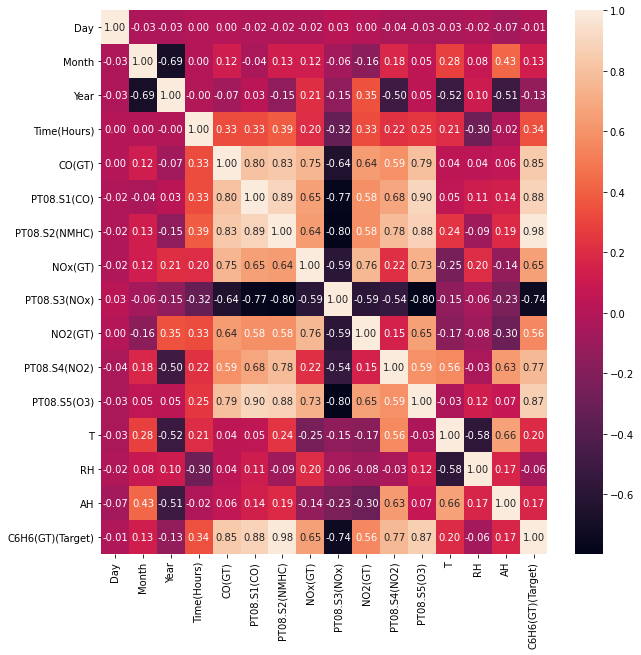

In [201]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data2.corr(method='pearson'),  annot=True, fmt='.2f')

In [202]:
for row in data2.corr():
    if data2.corr()[row]['C6H6(GT)(Target)'] >= 0.8:
        print(row, data2.corr()[row]['C6H6(GT)(Target)'])

CO(GT) 0.8452455496142565
PT08.S1(CO) 0.8837950766080735
PT08.S2(NMHC) 0.9819503158012699
PT08.S5(O3) 0.865688504505472
C6H6(GT)(Target) 1.0


Отбор признаков методом обёртывания

In [203]:
knn = KNeighborsRegressor()
efs1 = EFS(knn, 
           min_features=2,
           max_features=4,
           scoring='r2',
           print_progress=True,
           cv=5)
efs1 = efs1.fit(data2.drop(columns=['C6H6(GT)(Target)']), data2['C6H6(GT)(Target)'])
print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

Features: 1925/1925

Best accuracy score: 1.00
Best subset (indices): (6, 14)
Best subset (corresponding names): ('PT08.S2(NMHC)', 'AH')


Отбор признаков методом вложений

In [206]:
e_lr1 =  Lasso()
e_lr1.fit(data2.drop(columns=['C6H6(GT)(Target)']), data2['C6H6(GT)(Target)'])
# Коэффициенты регрессии
e_lr1.coef_

array([ 0.        , -0.        ,  0.        , -0.00770234,  0.        ,
        0.00178569,  0.02828697,  0.00360676,  0.00399853, -0.00807951,
        0.00011512, -0.        , -0.        ,  0.        , -0.        ])

In [210]:
sel_e_lr1 = SelectFromModel(e_lr1)
sel_e_lr1.fit(data2.drop(columns=['C6H6(GT)(Target)']), data2['C6H6(GT)(Target)'])
sel_e_lr1.get_support()

array([False, False, False,  True, False,  True,  True,  True,  True,
        True,  True, False, False, False, False])